In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from skimpy import skim

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
from pmdarima import pipeline, model_selection, preprocessing, arima
from pmdarima.arima import auto_arima

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [109]:
from prophet import Prophet

In [5]:
df = pd.read_csv('data/savings_change.csv', parse_dates=['date']).rename(columns={'delta_val': 'value'})

In [6]:
df

,date,value
0,1970-01-01,4.810312
1,1970-04-01,7.287992
2,1970-07-01,7.289013
3,1970-10-01,0.985230
4,1971-01-01,3.657771
...,...,...
182,2015-07-01,3.180930
183,2015-10-01,3.482786
184,2016-01-01,2.236534
185,2016-04-01,-2.721501


In [7]:
skim(df)

╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 187    │ │ datetime64  │ 1     │                                    │
│ │ Number of columns │ 2      │ │ float64     │ 1     │                                    │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                    │
│                                          number                                           │
│ ┏━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━┳━━━━━┳━━━━━━┳━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃        ┃ missing  ┃ complete rate   ┃ mean  ┃ sd  ┃ p0  ┃ p25  ┃ p75 ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━╇━━━━━╇━━━━━━╇━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ value  │        0 │               1 │   1.2 │  14 │ -69 │ -4.2 │ 6.7 │   51 │   ▁█▁  │  │
│ └────────┴──────────┴─────────────────┴───────┴─────┴─────┴──────┴─────┴──────┴────────┘  │
│                                         datetime                                          │
│ ┏━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃        ┃ missing    ┃ complete rate     ┃ first         ┃ last          ┃ frequency  ┃  │
│ ┡━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩  │
│ │ date   │          0 │                 1 │  1970-01-01   │  2016-07-01   │ QS-OCT     │  │
│ └────────┴────────────┴───────────────────┴───────────────┴───────────────┴────────────┘  │
╰─────────────────────────────────────────── End ───────────────────────────────────────────╯

<AxesSubplot:xlabel='date'>

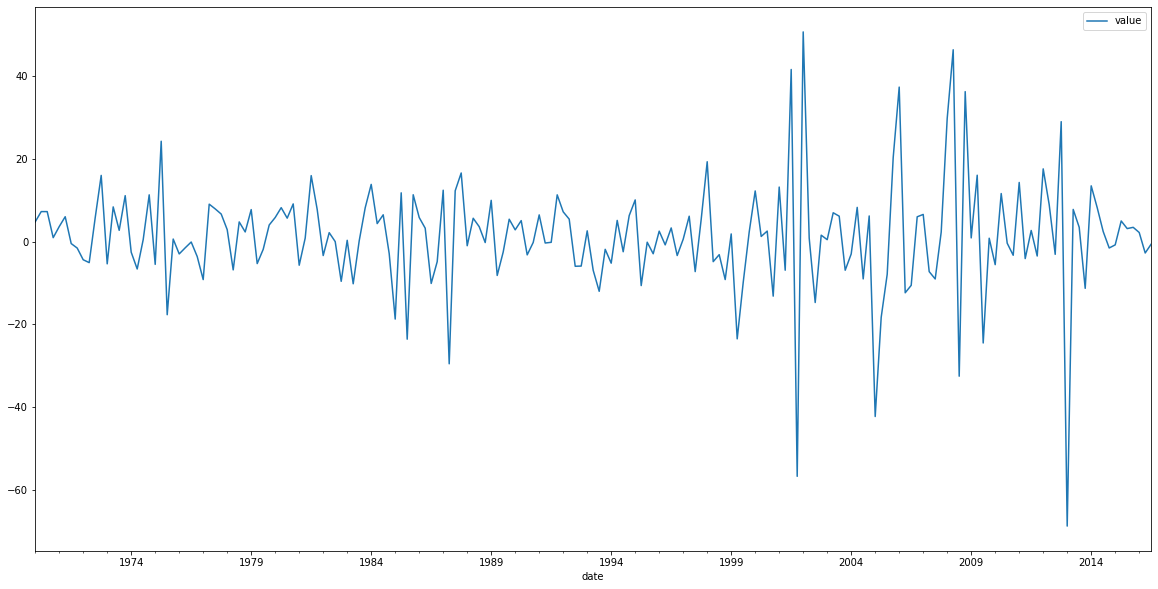

In [8]:
df.set_index(['date']).plot(figsize=(20, 10))

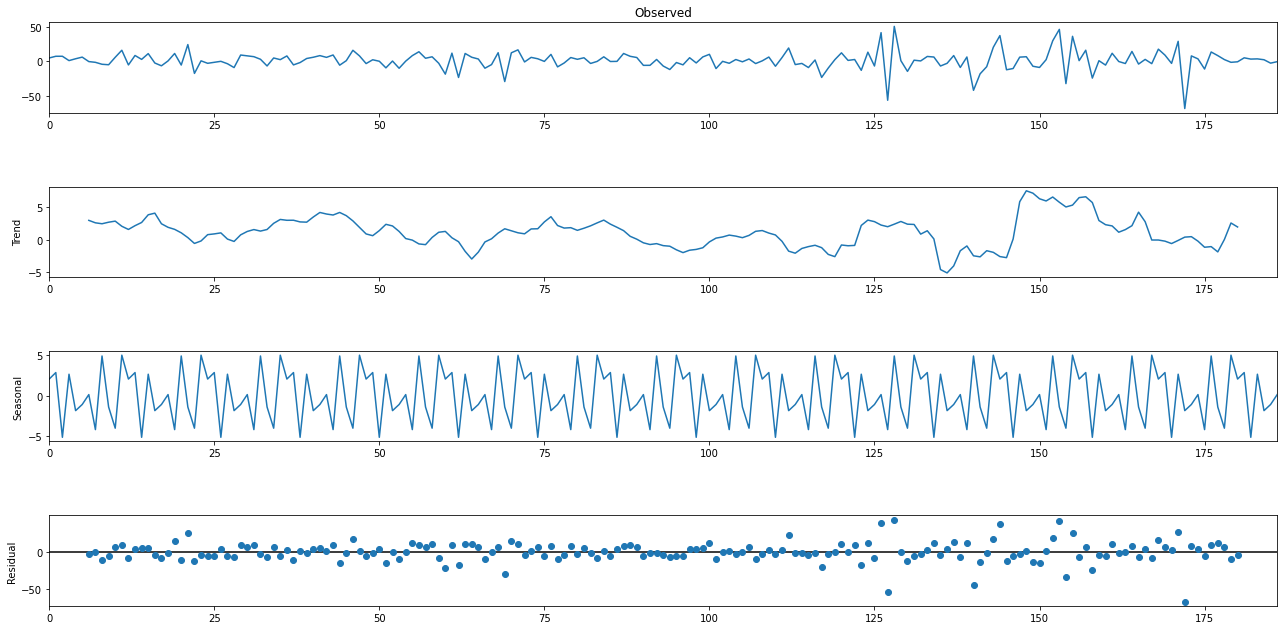

In [9]:
decomposition = seasonal_decompose(df['value'].to_numpy(), period=12)
fig = decomposition.plot();
fig.set_size_inches(20, 10)

In [10]:
result = adfuller(df['value'].to_numpy())
print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]:.3f}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

ADF Statistic: -18.706
p-value: 0.000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


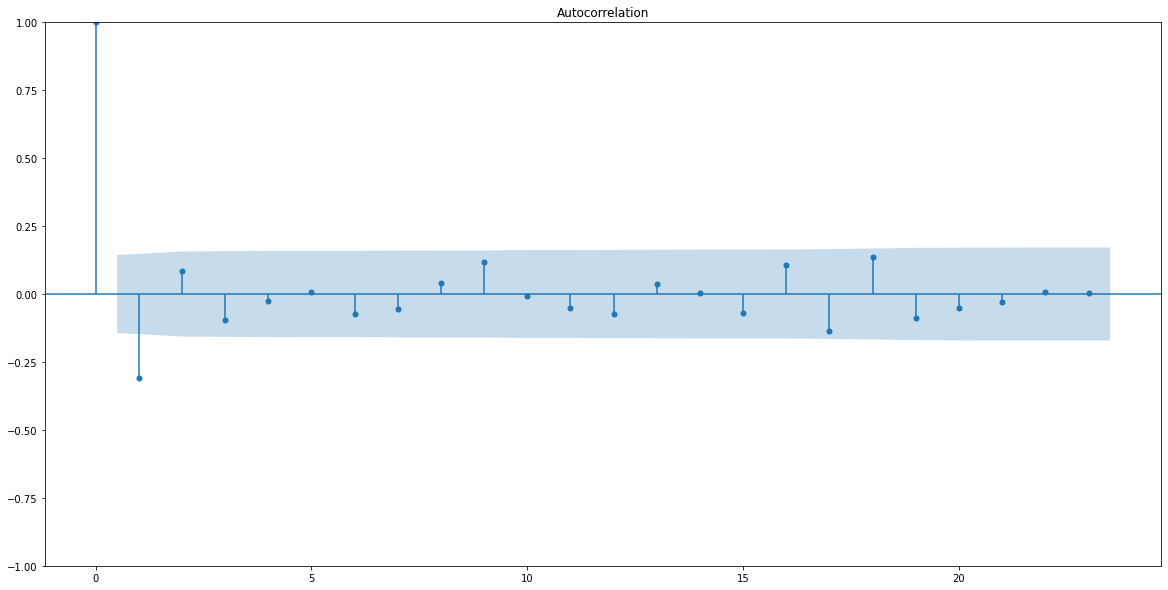

In [11]:
fig = plot_acf(df['value'])
fig.set_size_inches(20, 10)

/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


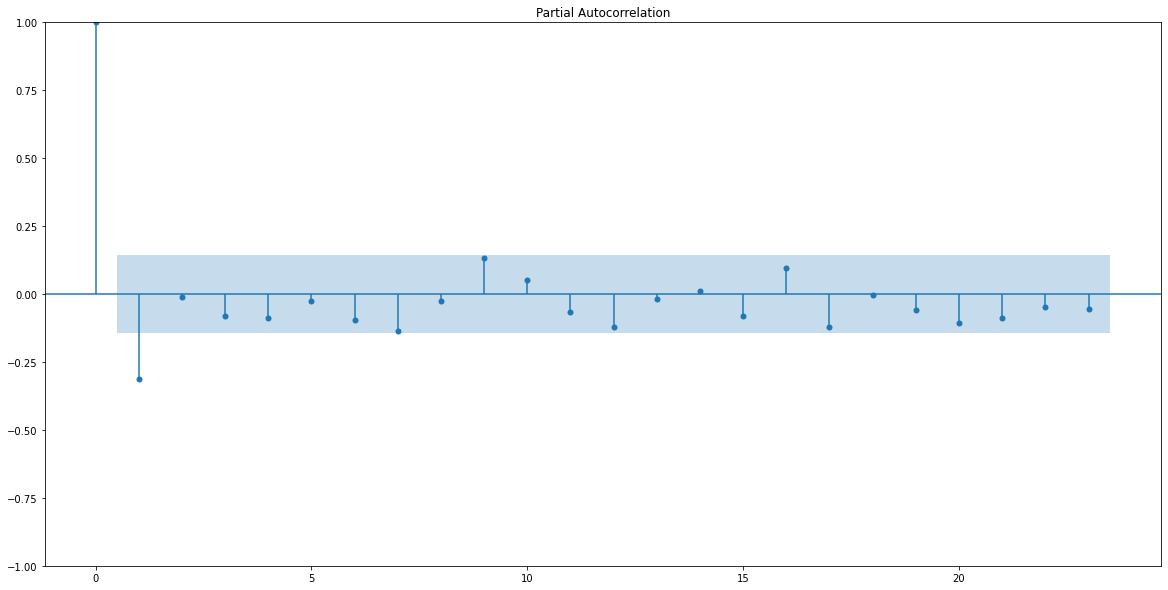

In [12]:
fig = plot_pacf(df['value'])
fig.set_size_inches(20, 10)

In [13]:
train_ds, valid_ds = train_test_split(df['value'], test_size=12, shuffle=False)

In [14]:
pipe = pipeline.Pipeline([
                    ('fourier', preprocessing.FourierFeaturizer(m=4)),
                    ('arima', arima.AutoARIMA(seasonal=False, error_action='ignore', suppress_warnings=True, trace=True))
                        ])

In [15]:
pipe.fit(train_ds)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1417.652, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1428.604, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1413.626, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1414.732, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1415.564, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1415.511, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1417.401, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1413.240, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1429.318, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1415.233, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1415.223, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1413.866, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1417.096, Time=0.31 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.491 seconds


Pipeline(steps=[('fourier', FourierFeaturizer(m=4)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False, trace=True))])

In [16]:
pipe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  175
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -699.620
Date:                Fri, 17 Jun 2022   AIC                           1413.240
Time:                        15:18:19   BIC                           1435.394
Sample:                             0   HQIC                          1422.226
                                - 175                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        1.5503      1.091      1.421      0.155      -0.588       3.689
FOURIER_S4-0     2.2632      1.465      1.545      0.122      -0.609       5.135
FOURIER_C4-0     0.6652      1.497      0.444      0.657      -2.268       3.599
FOURIER_S4-1  9.682e+04   3.97e+05      0.244      0.808   -6.82e+05    8.76e+05
FOURIER_C4-1    -0.0559      4.481     -0.012      0.990      -8.839       8.727
ar.L1           -0.3125      0.043     -7.312      0.000      -0.396      -0.229
sigma2         173.6642     11.068     15.691      0.000     151.972     195.357
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               206.40
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.35   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
forecasts, confident_interval = pipe.predict(n_periods= valid_ds.shape[0], return_conf_int=True)
result = pd.concat([valid_ds.reset_index(drop=True).rename('Ground-Truth'),
                    pd.Series(forecasts, name='Forecast'),
                    pd.DataFrame(confident_interval, columns=['C-Low', 'C-High'])
                   ], axis=1)
result

,Ground-Truth,Forecast,C-Low,C-High
0,-11.276615,1.404690,-24.424053,27.233433
1,13.520202,2.588137,-24.472635,29.648909
2,8.244048,1.783539,-25.394578,28.961656
3,2.461953,-2.484031,-29.673583,24.705520
4,-1.513050,3.296285,-23.894383,30.486953
5,-0.758400,1.973680,-25.217098,29.164457
6,5.023918,1.998851,-25.191937,29.189639
7,3.180930,-2.574599,-29.765388,24.616190
8,3.482786,3.347867,-23.842922,30.538656
9,2.236534,1.934282,-25.256507,29.125072


<AxesSubplot:>

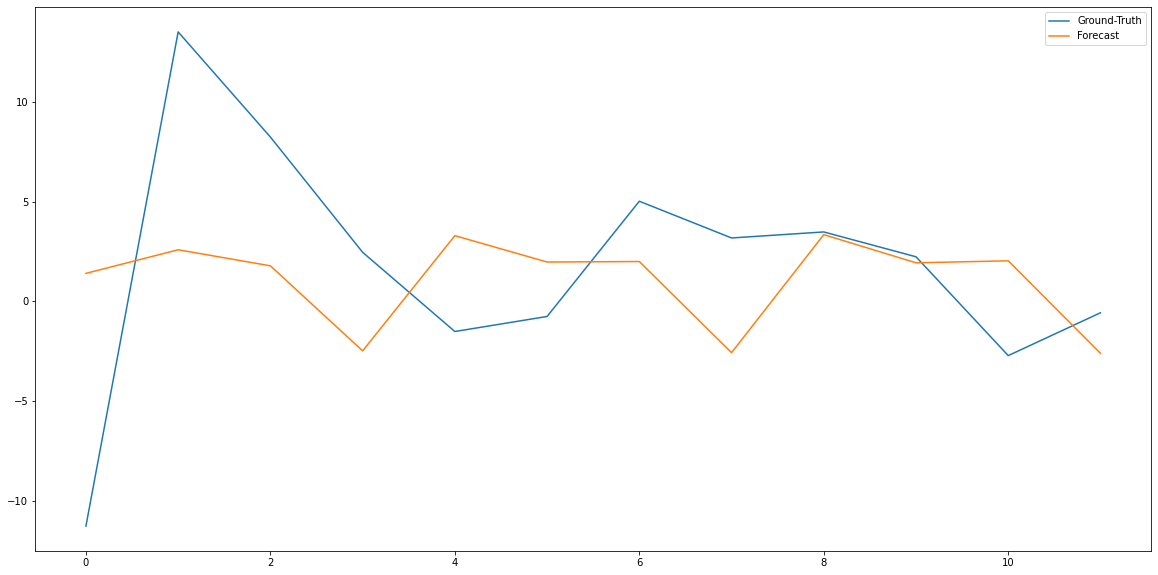

In [18]:
result.iloc[:, [0, 1]].plot(figsize=(20, 10))

In [19]:
df = pd.read_csv('data/tesla_prices_5y.csv', parse_dates=['Date'], usecols=['Date', 'Close'])

<AxesSubplot:>

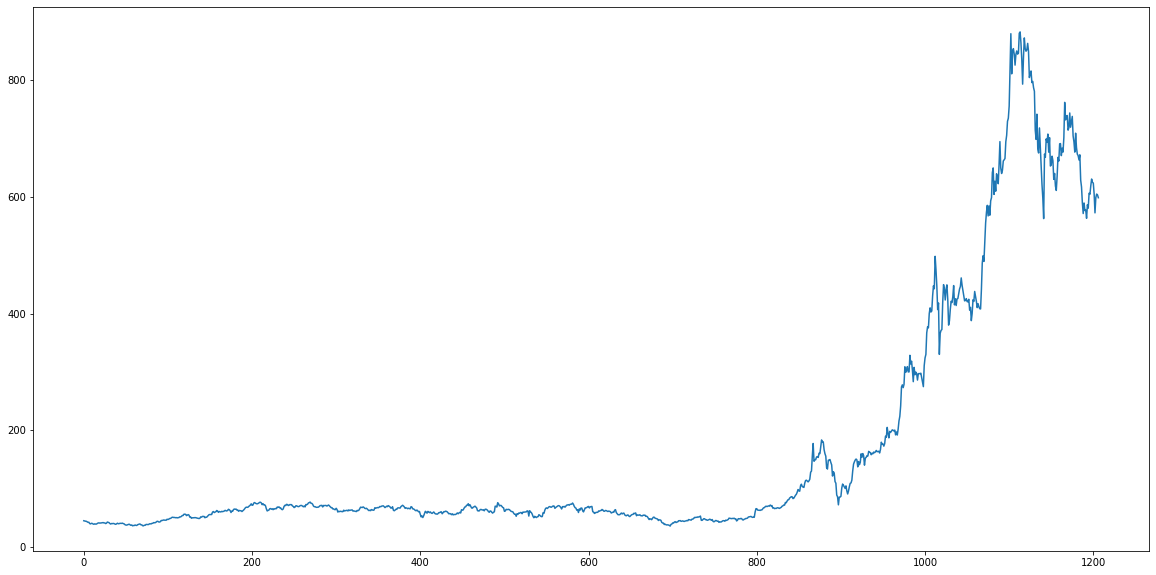

In [20]:
df['Close'].plot(figsize=(20, 10))

In [21]:
result = adfuller(df['Close'].to_numpy())
print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]:.3f}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

ADF Statistic: -0.223
p-value: 0.936
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


<AxesSubplot:>

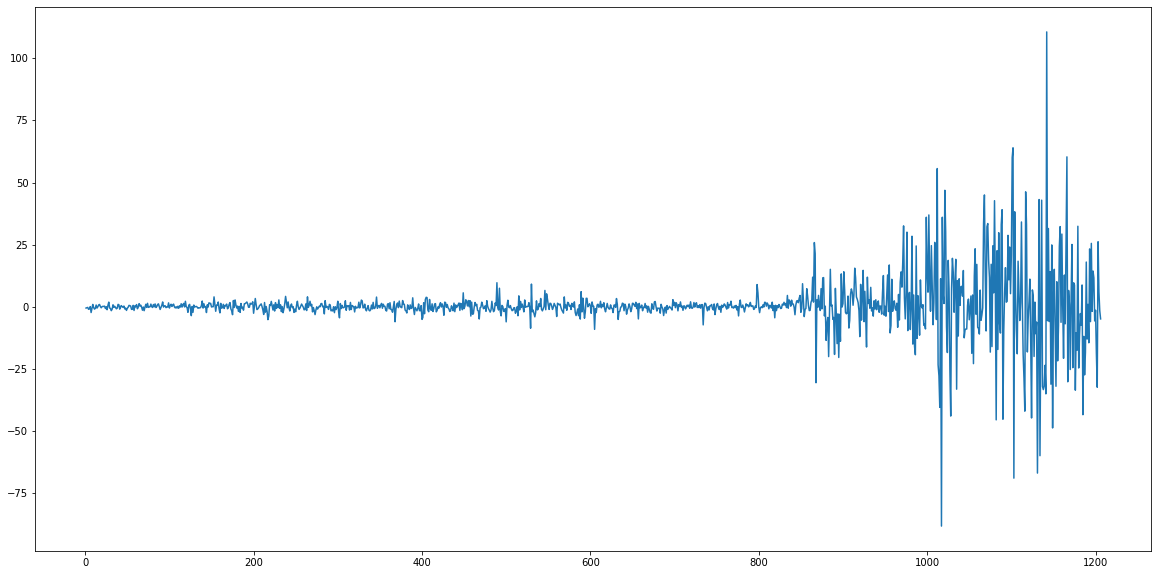

In [22]:
df['Close'].diff().dropna().plot(figsize=(20, 10))

In [23]:
result = adfuller(df['Close'].diff().dropna().to_numpy())
print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]:.3f}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

ADF Statistic: -5.940
p-value: 0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [24]:
train = pd.read_csv('data/train.csv', parse_dates=['date'], index_col=['date'])
test = pd.read_csv('data/test.csv', parse_dates=['date'], index_col=['date'])
df = pd.concat([train, test], sort=True).loc[lambda df_: (df_['item'] == 1) & (df_['store'] == 1), ['sales']]

In [25]:
df

,sales
date,
2013-01-01,13.0
2013-01-02,11.0
2013-01-03,14.0
2013-01-04,13.0
2013-01-05,10.0
...,...
2018-03-27,NaN
2018-03-28,NaN
2018-03-29,NaN


In [26]:
skim(df)

╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 1916   │ │ float64     │ 1     │                                    │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                    │
│ └───────────────────┴────────┘                                                            │
│                                          number                                           │
│ ┏━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃        ┃ missing  ┃ complete rate   ┃ mean  ┃ sd   ┃ p0  ┃ p25 ┃ p75 ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━╇━━━━━╇━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ sales  │       90 │            0.95 │    20 │  6.7 │   4 │  15 │  24 │   50 │  ▂█▇▃  │  │
│ └────────┴──────────┴─────────────────┴───────┴──────┴─────┴─────┴─────┴──────┴────────┘  │
╰─────────────────────────────────────────── End ───────────────────────────────────────────╯

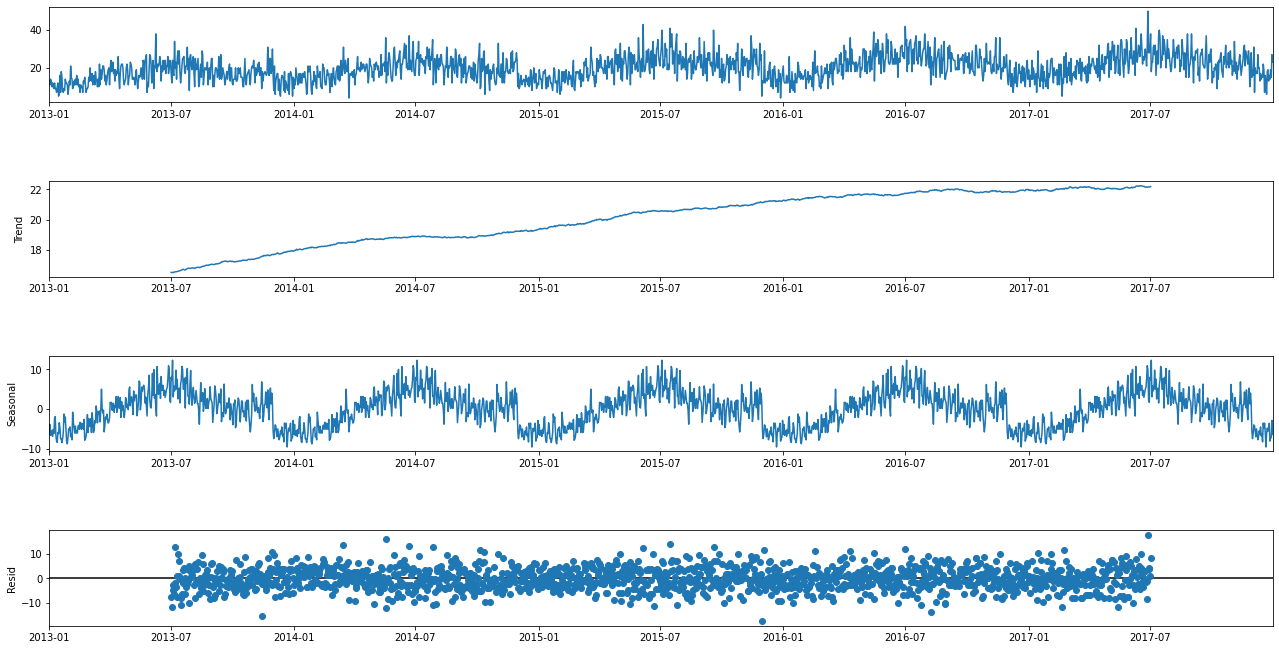

In [27]:
decomposition = seasonal_decompose(df.dropna(), period=365)
fig = decomposition.plot()
fig.set_size_inches(20, 10)

In [28]:
tr_start,tr_end = '2014-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
train_ds = df.loc[tr_start:tr_end, :].dropna()
test_ds = df.loc[te_start:te_end, :].dropna()

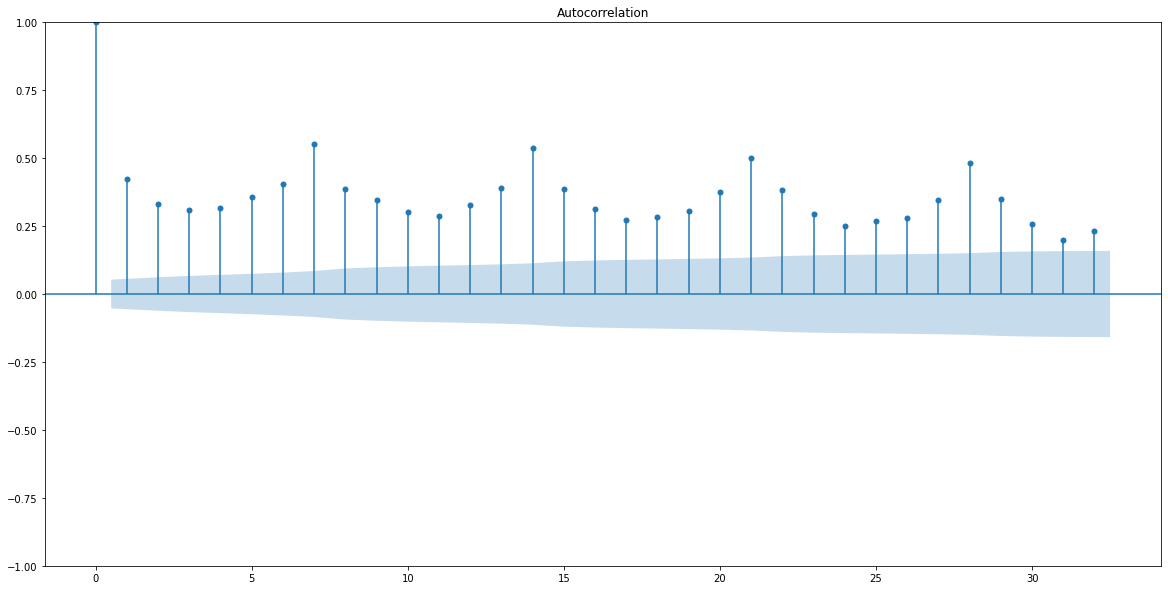

In [29]:
fig = plot_acf(train_ds);
fig.set_size_inches(20, 10)

/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


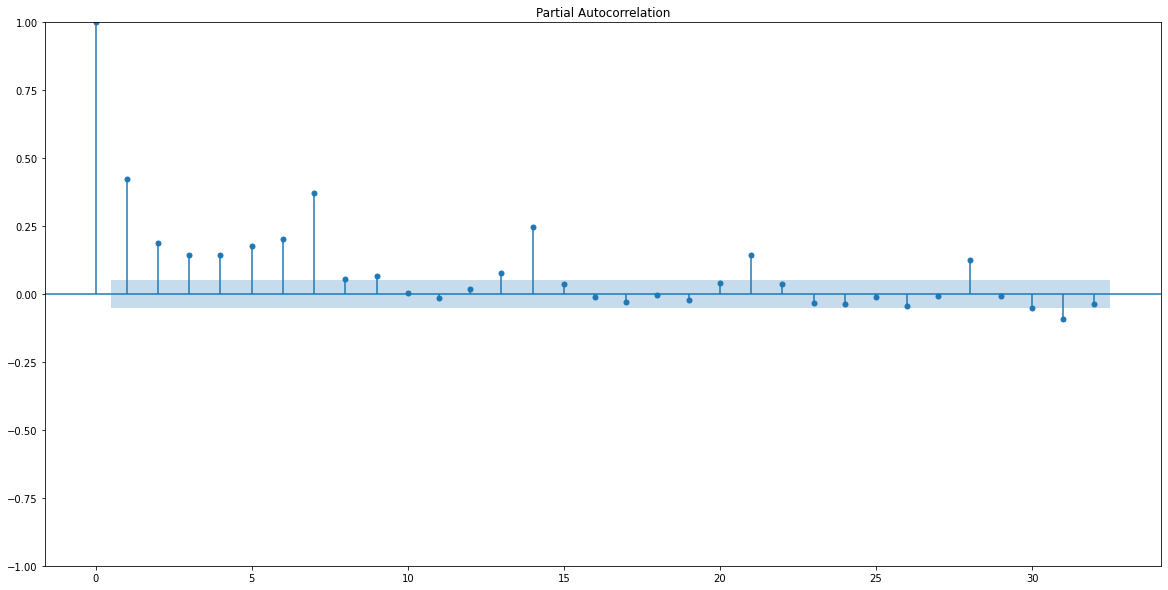

In [30]:
fig = plot_pacf(train_ds);
fig.set_size_inches(20, 10)

In [31]:
auto_model = auto_arima(train_ds, start_p=1, start_q=1 ,
                        test='adf',       
                        max_p=7, max_q=7, 
                        m=7,              
                        d=1,
                        seasonal=True,   
                        start_P=1, 
                        D=1, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True,
                        n_jobs=-1)

/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=5.28 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=9783.794, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=9076.573, Time=0.46 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=2.73 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=9482.428, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=8942.628, Time=1.02 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=8.02 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=3.99 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=9292.960, Time=0.65 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=8771.023, Time=1.21 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=8902.831, Time=0.73 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=10.76 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=6.04 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=8677.203, Time=1.54 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=8810.188, Time=0.94 

In [32]:
print(auto_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1369
Model:             SARIMAX(6, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -4277.811
Date:                           Fri, 17 Jun 2022   AIC                           8573.621
Time:                                   15:22:20   BIC                           8620.565
Sample:                                        0   HQIC                          8591.194
                                          - 1369                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8487      0.028    -30.292      0.000      -0.904      -0.794
ar.L2         -0.7342      0.036    -20.322

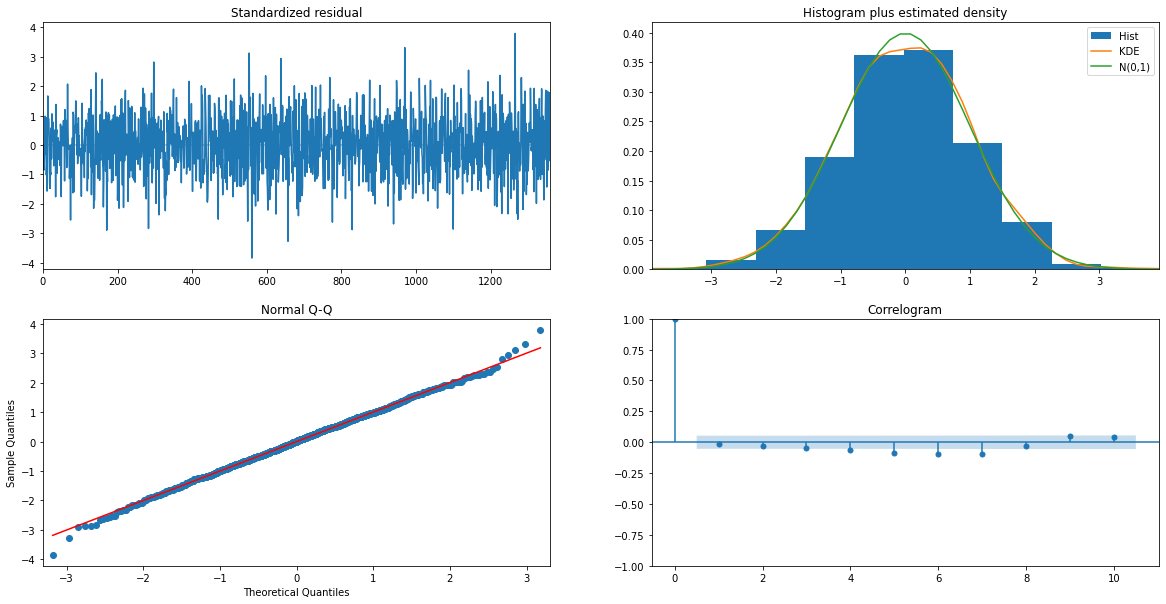

In [33]:
fig = auto_model.plot_diagnostics()
fig.set_size_inches(20, 10)

In [34]:
forecasts, confident_interval = auto_model.predict(n_periods=test_ds.shape[0], return_conf_int=True)
result = pd.concat([test_ds.reset_index(drop=True).squeeze().rename('Ground-Truth'),
                    pd.Series(forecasts, name='Forecast'),
                    pd.DataFrame(confident_interval, columns=['C-Low', 'C-High'])
                   ], axis=1)
result

,Ground-Truth,Forecast,C-Low,C-High
0,21.0,27.925030,16.952752,38.897308
1,12.0,18.100299,7.003174,29.197424
2,18.0,19.949636,8.750493,31.148779
3,15.0,20.141639,8.746465,31.536813
4,20.0,22.564522,10.915522,34.213522
...,...,...,...,...
87,14.0,23.098038,-84.627726,130.823802
88,19.0,22.786158,-86.420725,131.993041
89,15.0,28.508596,-82.205899,139.223091
90,27.0,32.564285,-79.630368,144.758938


<AxesSubplot:>

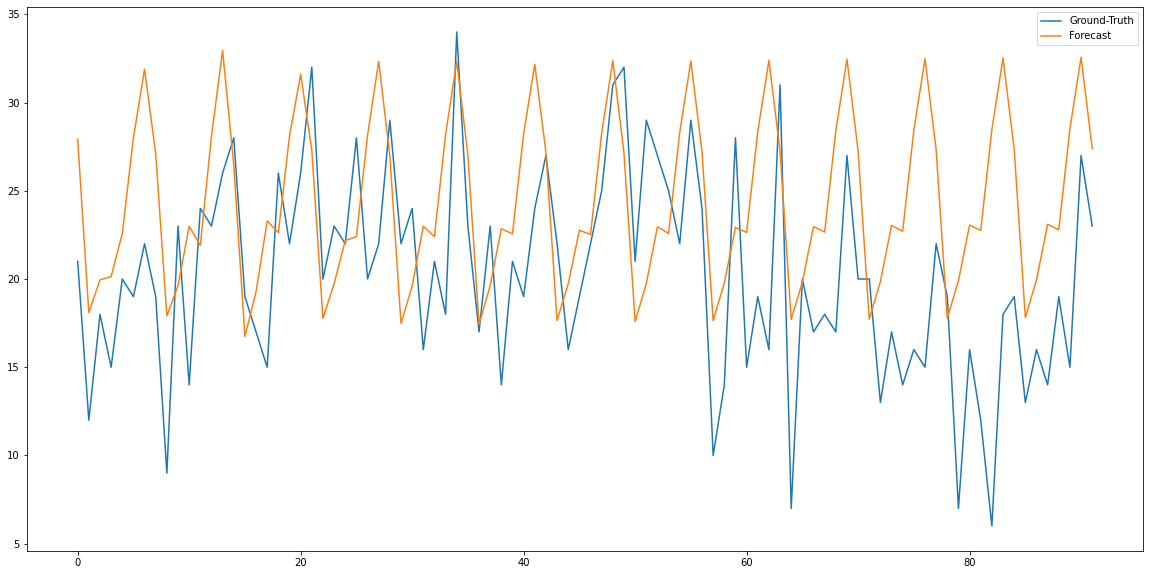

In [35]:
result.iloc[:, [0, 1]].plot(figsize=(20, 10))

In [113]:
df = pd.read_csv('data/TATASTEEL.csv', index_col=['Date'], parse_dates=['Date'], usecols=["Date", "High", "Low", "Volume", "VWAP"])

In [114]:
df.head()

,High,Low,VWAP,Volume
Date,,,,
2000-01-03,153.2,146.10,150.92,2003185
2000-01-04,153.0,143.05,151.03,1555136
2000-01-05,162.9,144.60,156.85,3840284
2000-01-06,169.1,158.95,167.61,2560449
2000-01-07,179.0,166.30,173.89,3641691


In [115]:
skim(df)

╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 5306   │ │ float64     │ 3     │                                    │
│ │ Number of columns │ 4      │ │ int64       │ 1     │                                    │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                    │
│                                          number                                           │
│ ┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┓  │
│ ┃        ┃ missin ┃ comple ┃ mean   ┃ sd     ┃ p0    ┃ p25    ┃ p75   ┃ p100   ┃ hist  ┃  │
│ ┃        ┃ g      ┃ te     ┃        ┃        ┃       ┃        ┃       ┃        ┃       ┃  │
│ ┃        ┃        ┃ rate   ┃        ┃        ┃       ┃        ┃       ┃        ┃       ┃  │
│ ┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━┩  │
│ │ High   │      0 │      1 │    410 │    190 │    70 │    280 │   530 │   1100 │ ▅▇█▄▁ │  │
│ │ Low    │      0 │      1 │    400 │    180 │    66 │    270 │   520 │   1000 │ ▅▆█▄▁ │  │
│ │ VWAP   │      0 │      1 │    400 │    190 │    68 │    280 │   530 │   1000 │ ▅▆█▄▁ │  │
│ │ Volume │      0 │      1 │ 620000 │ 530000 │ 23000 │ 280000 │ 78000 │ 640000 │  █▁   │  │
│ │        │        │        │      0 │      0 │       │      0 │    00 │     00 │       │  │
│ └────────┴────────┴────────┴────────┴────────┴───────┴────────┴───────┴────────┴───────┘  │
╰─────────────────────────────────────────── End ───────────────────────────────────────────╯

<AxesSubplot:xlabel='Date'>

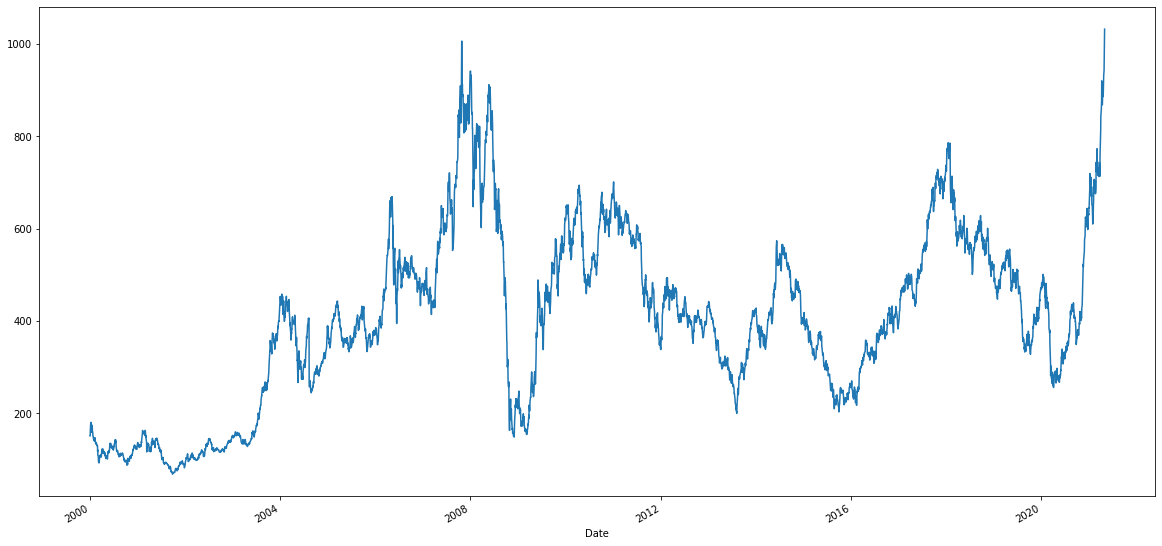

In [116]:
df['VWAP'].plot(figsize=(20, 10))

In [117]:
for col in ['High', 'Low', 'Volume']:
    df[f'{col}_mean_lag'] = df[col].rolling(3, min_periods=0).mean().shift(1)
    df[f'{col}_std_lag'] = df[col].rolling(3, min_periods=0).std().shift(1)

In [118]:
df.fillna(df.mean(), inplace=True)

In [119]:
df_train = df[df.index < "2019"]
df_valid = df[df.index >= "2019"]

In [120]:
df_train.shape, df_valid.shape

((4729, 10), (577, 10))

In [121]:
exogenous = ['High_mean_lag', 'High_std_lag', 'Low_mean_lag', 'Low_std_lag', 'Volume_mean_lag', 'Volume_std_lag']

In [161]:
arima_model = auto_arima(df_train['VWAP'], df_train[exogenous], 
                         m = 7,
                         max_p= 2, max_q=2,    
                         max_P = 1, max_Q = 1,
                         trace=True, error_action="ignore", suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=35921.269, Time=52.65 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=38986.123, Time=5.79 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=36339.065, Time=25.84 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=38867.406, Time=29.43 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=74270.674, Time=4.12 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=35919.583, Time=44.71 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=35920.888, Time=21.54 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=35919.194, Time=43.25 sec
 ARIMA(1,0,2)(1,0,0)[7] intercept   : AIC=35915.836, Time=32.76 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=35917.349, Time=19.50 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=35917.847, Time=39.60 sec
 ARIMA(1,0,2)(0,0,1)[7] intercept   : AIC=35916.140, Time=35.23 sec
 ARIMA(0,0,2)(1,0,0)[7] intercept   : AIC=36040.051, Time=35.10 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=36045.303, Time=30.86 sec
 ARIMA(

In [167]:
arima_model.fit(df_train['VWAP'], df_train.loc[:, exegenous])

ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(0, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [168]:
forecasts, confident_interval = arima_model.predict(df_valid.shape[0], df_valid.loc[:, exegenous], return_conf_int=True)
arima_result = pd.concat([df_valid['VWAP'].reset_index(drop=True).squeeze().rename('Ground-Truth'),
                    pd.Series(forecasts, name='A-Forecast'),
                    pd.DataFrame(confident_interval, columns=['A-C-Low', 'A-C-High'])
                   ], axis=1)
arima_result

/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Ground-Truth,A-Forecast,A-C-Low,A-C-High
0,516.59,523.821348,503.990530,543.652165
1,499.63,523.042280,496.610858,549.473703
2,485.96,515.652671,487.422863,543.882478
3,484.60,504.380139,476.048902,532.711377
4,492.72,490.783449,462.446302,519.120595
...,...,...,...,...
572,942.98,917.282975,888.943984,945.621967
573,965.43,929.393179,901.054187,957.732171
574,972.08,943.180821,914.841829,971.519813
575,1015.76,959.064537,930.725545,987.403529


<AxesSubplot:>

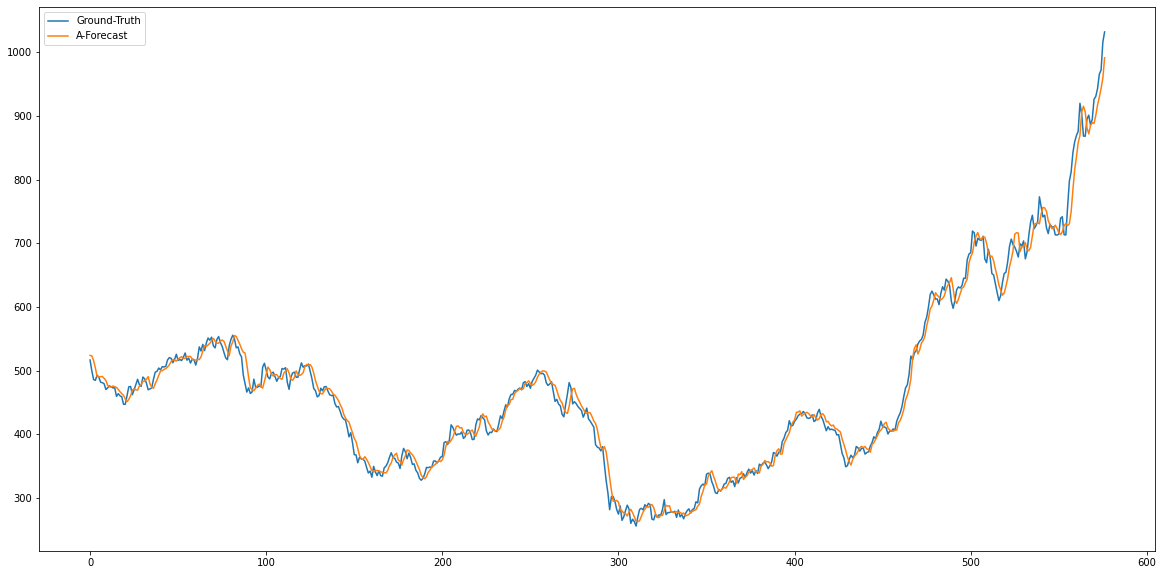

In [169]:
arima_result.iloc[:, [0, 1]].plot(figsize=(20, 10))

In [133]:
df_prophet = df_train.reset_index().rename(columns={'Date': 'ds', 'VWAP': 'y'}).loc[:, ['ds', 'y'] + exegenous]

In [135]:
prophet_model = Prophet()
for col in exegenous:
    prophet_model.add_regressor(col)

In [136]:
prophet_model.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -74.4543


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       17575.6    0.00293968       6428.77           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       17601.1   0.000186478       1110.51           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       17606.9   0.000108591       684.705           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       17609.4    0.00127528       1204.24           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       17610.6   0.000416583       1002.05           1           1      550   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [147]:
prophet_result = (prophet_model.predict(df_valid.reset_index().rename(columns={'Date': 'ds', 'VWAP': 'y'}).loc[:, ['ds', 'y'] + exegenous])
                         .loc[:, ['yhat', 'yhat_lower', 'yhat_upper']].rename(columns={'yhat': 'P-Forecast', 'yhat_lower': 'P-C-Low', 'P-yhat_upper': 'P-C-Hight'}))

/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [170]:
result = pd.concat([arima_result, prophet_result], axis=1)

<AxesSubplot:>

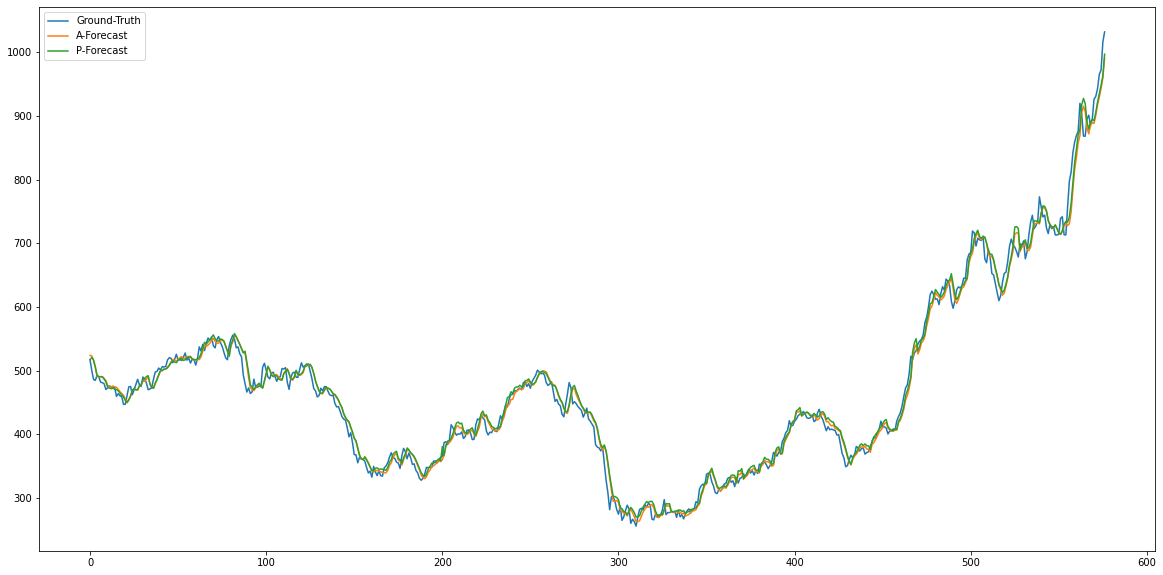

In [171]:
result.iloc[:, [0, 1, 4]].plot(figsize=(20, 10))  # COMPLETE DATA LEAKAGE! JUST FOLLOWING THE ORIGINAL NOTEBOOK!

In [175]:
print("RMSE of SARIMAX:", np.sqrt(mean_squared_error(result['Ground-Truth'], result['A-Forecast'])))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(result['Ground-Truth'], result['P-Forecast'])))

RMSE of SARIMAX: 15.471923788043947
RMSE of Prophet: 15.3494117600684
